### **Mount Google Drive/Parent Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### **Install and Import Libraries**

In [ ]:
!pip install pytorchtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import pickle
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import Lambda
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
import time


In [ ]:
#### GPU Info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 12 20:45:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |    572MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Loss Functions**

### **Evaluation Metrics**

### **Dataset Loading**

In [ ]:
# To make all the images square so that there is no information loss during squeezing
class ResizeSquare(object):
    def __call__(self, img):
        x, y = img.size 
        size = max(x, y)
        new_im = Image.new('RGB', (size, size), (0,0,0))
        new_im.paste(img, (int((size - x) / 2), int((size - y) / 2))) 
        return new_im

In [ ]:
# Parameters
SIZE = 256
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
DELTA= 0
NUM_WORKERS = 2
MAX_NUM_EPOCHS=100
EARLY_STOP_PATIENCE = 3

# Directories

input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD_Project_DL/Dataset/Binary Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'
models_directory= input_directory + '/models'
statistics_directory= input_directory +'/statistics'

In [ ]:
#Calculating the mean and stdv of the Dataset

def CalculateMeanStdDataset(dataset_directory,num_channels):

  cls_mean = torch.zeros((1,num_channels))
  cls_stdv = torch.zeros((1,num_channels))
  mean = torch.zeros((1,num_channels))
  stdv = torch.zeros((1,num_channels))
  paths = os.listdir(dataset_directory)

  for cls in paths:
    cls_directory = dataset_directory + '/' + cls
    imgs = os.listdir(cls_directory)
    for idx in range(len(imgs)):
      img_path = imgs[idx]
      img_directory = os.path.join(cls_directory, img_path)
      image = Image.open(img_directory)
      img = TF.to_tensor(image)
      cls_mean += torch.mean(img, axis = [1,2])
      cls_stdv += torch.std(img, axis = [1,2])
    cls_mean = cls_mean/len(imgs)
    cls_stdv = cls_stdv/len(imgs)
    mean += cls_mean
    stdv += cls_stdv 
  mean = mean/len(paths)
  stdv = stdv/len(paths)

  return mean,stdv


In [ ]:
#mu,std= CalculateMeanStdDataset(train_directory,3)

In [ ]:
#torch.save(mu, statistics_directory+'/train_mu.pt')
#torch.save(std, statistics_directory+'/train_std.pt')

In [ ]:
mu= torch.load(statistics_directory+'/train_mu.pt')
std= torch.load(statistics_directory+'/train_std.pt')

In [ ]:
mu_list= mu[0].tolist()
std_list= std[0].tolist()

In [ ]:
# Matplotlib's PyPlot to show an image stored in a pytorch tensor 
def im_show(inp,mean,std, title=None):
  """
    Parameters: 
      * inp: the image that we want to show (it needs to have 3 channels, numpy does not show grayscale images)
      * title (optional): the title to show with the image
  """
  inp = inp.numpy().transpose((1, 2, 0)) # Convert from HxWxC format of tensor to CxHxW format of numpy
  inp = std * inp + mean # Denormalize image
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp) # Show the image 
  if title is not None:
      plt.title(title) # Add a title if provided
  plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Transforms for preprocessing
img_transforms = transforms.Compose([
                                    #ResizeSquare(), # For original images
                                    transforms.Resize((SIZE, SIZE)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(45),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu_list, std=std_list)
                                  ])  

In [ ]:
# Define a mapping from original labels to new labels
#labels= ['bcc','mel','scc']
#label_map = {'mel': 0, 'bcc': 1, 'scc': 2}
# Create a function that takes in a label and returns the new label
#def label_transform(label):
#    return label_map[label]

In [ ]:
# training dataset
train_dataset = datasets.ImageFolder(
    root=train_directory,
    transform=img_transforms,
    #target_transform= Lambda(lambda y: label_transform(labels[y]))
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root=val_directory,
    transform=img_transforms,
    #target_transform= Lambda(lambda y: label_transform(labels[y]))
)
# training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
# validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

torch.Size([16, 3, 224, 224])
torch.Size([16])


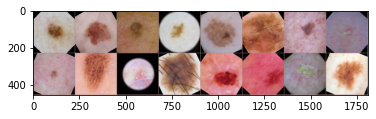

tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])


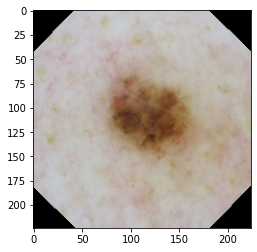

In [ ]:
# Visualize some examples

iterator = iter(train_loader)
data = next(iterator)

(images, labels) = data

print(images.shape)
print(labels.shape)

ins = torchvision.utils.make_grid(images)
im_show(ins,mu_list,std_list)
print(labels)
im_show(images[0],mu_list,std_list)

# Training model function

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):

    since = time.time()
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    early_stopper = EarlyStopper(patience=1, min_delta=0)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    break_loop= False

    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)
        if epoch != 0: 
          print('-' * 70)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            pbar= tqdm(dataloaders[phase])
            for i, (inputs, labels) in enumerate(pbar):
                inputs = inputs.to(device)
                labels = labels.to(device)

                #pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}')
                pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} , {} Accuracy: {:.4f}'.format(phase,epoch_loss, phase, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == 'val' and early_stopper.early_stop(epoch_loss):  
                print("Early stopping at epoch:", epoch)
                break_loop = True
        if break_loop == True: 
          break   
              
    time_elapsed = time.time() - since
    print('-'*70)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_model_wts, train_acc_history, train_loss_history, val_acc_history, val_loss_history

# Model 1

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(weights=True)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataloaders= {'train':train_loader,'val': valid_loader}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_1, train_acc_m1, train_loss_m1, val_acc_m1, val_loss_m1= train_model(model,dataloaders,criterion,optimizer, 25, False)

Epoch 1/25: 100%|██████████| 238/238 [08:30<00:00,  2.15s/it]


train Loss: 0.4848 , train Accuracy: 0.7797


Epoch 1/25: 100%|██████████| 60/60 [01:55<00:00,  1.92s/it]


val Loss: 0.3929 , val Accuracy: 0.8195
----------------------------------------------------------------------


Epoch 2/25: 100%|██████████| 238/238 [08:23<00:00,  2.12s/it]


train Loss: 0.3888 , train Accuracy: 0.8306


Epoch 2/25: 100%|██████████| 60/60 [01:55<00:00,  1.92s/it]


val Loss: 0.5099 , val Accuracy: 0.7761
----------------------------------------------------------------------


Epoch 3/25: 100%|██████████| 238/238 [08:28<00:00,  2.14s/it]


train Loss: 0.3473 , train Accuracy: 0.8496


Epoch 3/25: 100%|██████████| 60/60 [01:51<00:00,  1.85s/it]


val Loss: 0.4510 , val Accuracy: 0.8053
----------------------------------------------------------------------


Epoch 4/25: 100%|██████████| 238/238 [08:30<00:00,  2.14s/it]


train Loss: 0.2830 , train Accuracy: 0.8792


Epoch 4/25: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


val Loss: 0.4378 , val Accuracy: 0.8119
----------------------------------------------------------------------


Epoch 5/25: 100%|██████████| 238/238 [08:22<00:00,  2.11s/it]


train Loss: 0.2534 , train Accuracy: 0.8947


Epoch 5/25: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


val Loss: 0.3282 , val Accuracy: 0.8580
----------------------------------------------------------------------


Epoch 6/25: 100%|██████████| 238/238 [08:28<00:00,  2.14s/it]


train Loss: 0.2100 , train Accuracy: 0.9127


Epoch 6/25: 100%|██████████| 60/60 [01:50<00:00,  1.85s/it]


val Loss: 0.3974 , val Accuracy: 0.8440
----------------------------------------------------------------------


Epoch 7/25: 100%|██████████| 238/238 [08:26<00:00,  2.13s/it]


train Loss: 0.1774 , train Accuracy: 0.9316


Epoch 7/25: 100%|██████████| 60/60 [01:52<00:00,  1.87s/it]


val Loss: 0.4050 , val Accuracy: 0.8388
----------------------------------------------------------------------


Epoch 8/25: 100%|██████████| 238/238 [08:34<00:00,  2.16s/it]


train Loss: 0.1249 , train Accuracy: 0.9517


Epoch 8/25: 100%|██████████| 60/60 [01:55<00:00,  1.93s/it]


val Loss: 0.4993 , val Accuracy: 0.8572
----------------------------------------------------------------------


Epoch 9/25: 100%|██████████| 238/238 [09:00<00:00,  2.27s/it]


train Loss: 0.1174 , train Accuracy: 0.9556


Epoch 9/25: 100%|██████████| 60/60 [01:54<00:00,  1.92s/it]


val Loss: 0.5477 , val Accuracy: 0.8393
----------------------------------------------------------------------


Epoch 10/25: 100%|██████████| 238/238 [08:22<00:00,  2.11s/it]


train Loss: 0.0940 , train Accuracy: 0.9639


Epoch 10/25: 100%|██████████| 60/60 [01:54<00:00,  1.91s/it]


val Loss: 0.5575 , val Accuracy: 0.8330
----------------------------------------------------------------------


Epoch 11/25: 100%|██████████| 238/238 [08:22<00:00,  2.11s/it]


train Loss: 0.0879 , train Accuracy: 0.9687


Epoch 11/25: 100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


val Loss: 0.5580 , val Accuracy: 0.8161
----------------------------------------------------------------------


Epoch 12/25: 100%|██████████| 238/238 [08:21<00:00,  2.11s/it]


train Loss: 0.0621 , train Accuracy: 0.9765


Epoch 12/25: 100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


val Loss: 0.4975 , val Accuracy: 0.8572
----------------------------------------------------------------------


Epoch 13/25: 100%|██████████| 238/238 [08:21<00:00,  2.11s/it]


train Loss: 0.0488 , train Accuracy: 0.9824


Epoch 13/25: 100%|██████████| 60/60 [01:53<00:00,  1.89s/it]


val Loss: 0.5333 , val Accuracy: 0.8625
----------------------------------------------------------------------


Epoch 14/25: 100%|██████████| 238/238 [08:12<00:00,  2.07s/it]


train Loss: 0.0501 , train Accuracy: 0.9812


Epoch 14/25: 100%|██████████| 60/60 [01:51<00:00,  1.85s/it]


val Loss: 0.5797 , val Accuracy: 0.8612
----------------------------------------------------------------------


Epoch 15/25: 100%|██████████| 238/238 [08:10<00:00,  2.06s/it]


train Loss: 0.0312 , train Accuracy: 0.9896


Epoch 15/25: 100%|██████████| 60/60 [01:51<00:00,  1.86s/it]


val Loss: 0.6647 , val Accuracy: 0.8348
----------------------------------------------------------------------


Epoch 16/25: 100%|██████████| 238/238 [08:16<00:00,  2.08s/it]


train Loss: 0.0403 , train Accuracy: 0.9858


Epoch 16/25: 100%|██████████| 60/60 [01:53<00:00,  1.89s/it]


val Loss: 0.4805 , val Accuracy: 0.8662
----------------------------------------------------------------------


Epoch 17/25: 100%|██████████| 238/238 [08:34<00:00,  2.16s/it]


train Loss: 0.0327 , train Accuracy: 0.9888


Epoch 17/25: 100%|██████████| 60/60 [01:52<00:00,  1.88s/it]


val Loss: 0.6668 , val Accuracy: 0.8535
----------------------------------------------------------------------


Epoch 18/25: 100%|██████████| 238/238 [08:31<00:00,  2.15s/it]


train Loss: 0.0356 , train Accuracy: 0.9882


Epoch 18/25: 100%|██████████| 60/60 [01:55<00:00,  1.93s/it]


val Loss: 0.6332 , val Accuracy: 0.8691
----------------------------------------------------------------------


Epoch 19/25: 100%|██████████| 238/238 [08:30<00:00,  2.14s/it]


train Loss: 0.0244 , train Accuracy: 0.9910


Epoch 19/25: 100%|██████████| 60/60 [01:55<00:00,  1.93s/it]


val Loss: 0.7088 , val Accuracy: 0.8614
----------------------------------------------------------------------


Epoch 20/25: 100%|██████████| 238/238 [08:28<00:00,  2.14s/it]


train Loss: 0.0368 , train Accuracy: 0.9878


Epoch 20/25: 100%|██████████| 60/60 [01:54<00:00,  1.91s/it]


val Loss: 0.5925 , val Accuracy: 0.8554
----------------------------------------------------------------------


Epoch 21/25: 100%|██████████| 238/238 [08:25<00:00,  2.12s/it]


train Loss: 0.0164 , train Accuracy: 0.9953


Epoch 21/25: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


val Loss: 0.5942 , val Accuracy: 0.8664
----------------------------------------------------------------------


Epoch 22/25: 100%|██████████| 238/238 [08:17<00:00,  2.09s/it]


train Loss: 0.0122 , train Accuracy: 0.9963


Epoch 22/25: 100%|██████████| 60/60 [01:48<00:00,  1.80s/it]


val Loss: 0.6704 , val Accuracy: 0.8736
----------------------------------------------------------------------


Epoch 23/25: 100%|██████████| 238/238 [08:23<00:00,  2.12s/it]


train Loss: 0.0226 , train Accuracy: 0.9934


Epoch 23/25: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


val Loss: 0.9192 , val Accuracy: 0.8267
----------------------------------------------------------------------


Epoch 24/25: 100%|██████████| 238/238 [08:24<00:00,  2.12s/it]


train Loss: 0.0231 , train Accuracy: 0.9920


Epoch 24/25: 100%|██████████| 60/60 [01:51<00:00,  1.86s/it]


val Loss: 0.6303 , val Accuracy: 0.8604
----------------------------------------------------------------------


Epoch 25/25: 100%|██████████| 238/238 [08:29<00:00,  2.14s/it]


train Loss: 0.0156 , train Accuracy: 0.9949


Epoch 25/25: 100%|██████████| 60/60 [01:51<00:00,  1.86s/it]

val Loss: 0.7358 , val Accuracy: 0.8646
Training complete in 257m 42s
Best val Acc: 0.873551


In [ ]:
import pickle
pickle.dump(model_1, open(models_directory+'/first_model.sav', 'wb'))
pickle.dump(train_acc_m1, open(models_directory+'/train_acc_m1.sav', 'wb'))
pickle.dump(train_loss_m1, open(models_directory+'/train_loss_m1.sav', 'wb'))
pickle.dump(val_acc_m1, open(models_directory+'/val_acc_m1.sav', 'wb'))
pickle.dump(val_loss_m1, open(models_directory+'/val_loss_m1.sav', 'wb'))


In [ ]:
model_1= pickle.load(open(models_directory+'/first_model.sav', 'rb'))
train_acc_m1= pickle.load(open(models_directory+  '/train_acc_m1.sav', 'rb'))
train_loss_m1= pickle.load(open(models_directory+'/train_loss_m1.sav', 'rb'))
val_acc_m1= pickle.load(open(models_directory+'/val_acc_m1.sav', 'rb'))
val_loss_m1= pickle.load(open(models_directory+'/val_loss_m1.sav', 'rb'))

In [ ]:
summary()

In [ ]:
summary(model_1, input_size=(3,512,512), batch_size=64 )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 256, 256]           9,408
       BatchNorm2d-2         [64, 64, 256, 256]             128
              ReLU-3         [64, 64, 256, 256]               0
         MaxPool2d-4         [64, 64, 128, 128]               0
            Conv2d-5         [64, 64, 128, 128]          36,864
       BatchNorm2d-6         [64, 64, 128, 128]             128
              ReLU-7         [64, 64, 128, 128]               0
            Conv2d-8         [64, 64, 128, 128]          36,864
       BatchNorm2d-9         [64, 64, 128, 128]             128
             ReLU-10         [64, 64, 128, 128]               0
       BasicBlock-11         [64, 64, 128, 128]               0
           Conv2d-12         [64, 64, 128, 128]          36,864
      BatchNorm2d-13         [64, 64, 128, 128]             128
             ReLU-14         [64, 64, 1

In [ ]:
n_epochs=25

In [ ]:
train_acc_m1[0].tolist()

0.7797301743994736

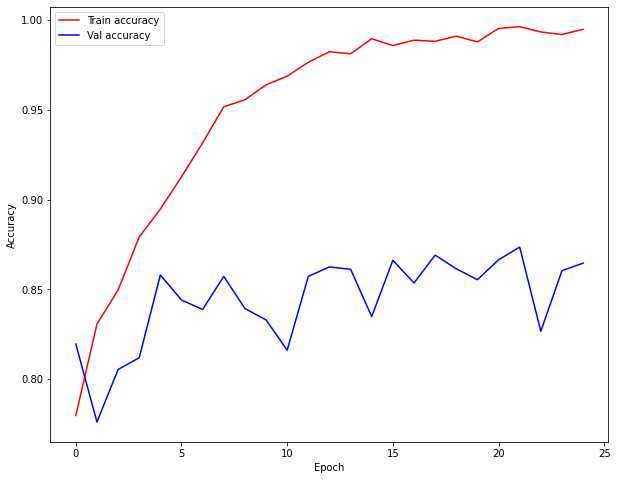

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m1],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m1],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



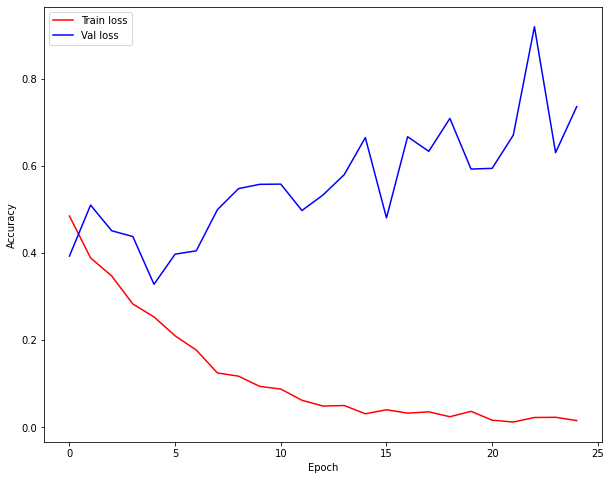

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m1,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m1,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model 2

Model 2

In [ ]:
#BATCH SIZE: 16

# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(weights=True)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(64, 2)  # Final classification layer with 2 outputs

)

# Move the model to the device
model = model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataloaders= {'train':train_loader,'val': valid_loader}

In [ ]:
model_2,weights_m2, train_acc_m2, train_loss_m2, val_acc_m2, val_loss_m2= train_model(model,dataloaders,criterion,optimizer, 50, False)

Epoch 1/25: 100%|██████████| 950/950 [04:58<00:00,  3.18it/s]


train Loss: 0.5432 , train Accuracy: 0.7387


Epoch 1/25: 100%|██████████| 238/238 [19:45<00:00,  4.98s/it]


val Loss: 0.4780 , val Accuracy: 0.7840
----------------------------------------------------------------------


Epoch 2/25: 100%|██████████| 950/950 [05:00<00:00,  3.16it/s]


train Loss: 0.4858 , train Accuracy: 0.7847


Epoch 2/25: 100%|██████████| 238/238 [01:07<00:00,  3.50it/s]


val Loss: 0.4245 , val Accuracy: 0.8180
----------------------------------------------------------------------


Epoch 3/25: 100%|██████████| 950/950 [04:59<00:00,  3.18it/s]


train Loss: 0.4500 , train Accuracy: 0.7996


Epoch 3/25: 100%|██████████| 238/238 [01:08<00:00,  3.45it/s]


val Loss: 0.4163 , val Accuracy: 0.8145
----------------------------------------------------------------------


Epoch 4/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.4373 , train Accuracy: 0.8129


Epoch 4/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.4302 , val Accuracy: 0.7953
----------------------------------------------------------------------


Epoch 5/25: 100%|██████████| 950/950 [04:58<00:00,  3.18it/s]


train Loss: 0.4165 , train Accuracy: 0.8242


Epoch 5/25: 100%|██████████| 238/238 [01:07<00:00,  3.50it/s]


val Loss: 0.4325 , val Accuracy: 0.8022
----------------------------------------------------------------------


Epoch 6/25: 100%|██████████| 950/950 [04:57<00:00,  3.19it/s]


train Loss: 0.4014 , train Accuracy: 0.8299


Epoch 6/25: 100%|██████████| 238/238 [01:08<00:00,  3.48it/s]


val Loss: 0.4466 , val Accuracy: 0.8227
----------------------------------------------------------------------


Epoch 7/25: 100%|██████████| 950/950 [04:58<00:00,  3.19it/s]


train Loss: 0.3897 , train Accuracy: 0.8346


Epoch 7/25: 100%|██████████| 238/238 [01:08<00:00,  3.49it/s]


val Loss: 0.4233 , val Accuracy: 0.8235
----------------------------------------------------------------------


Epoch 8/25: 100%|██████████| 950/950 [05:00<00:00,  3.16it/s]


train Loss: 0.3753 , train Accuracy: 0.8407


Epoch 8/25: 100%|██████████| 238/238 [01:08<00:00,  3.46it/s]


val Loss: 0.3818 , val Accuracy: 0.8256
----------------------------------------------------------------------


Epoch 9/25: 100%|██████████| 950/950 [05:00<00:00,  3.17it/s]


train Loss: 0.3747 , train Accuracy: 0.8471


Epoch 9/25: 100%|██████████| 238/238 [01:07<00:00,  3.52it/s]


val Loss: 0.3640 , val Accuracy: 0.8380
----------------------------------------------------------------------


Epoch 10/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.3450 , train Accuracy: 0.8576


Epoch 10/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.3929 , val Accuracy: 0.8253
----------------------------------------------------------------------


Epoch 11/25: 100%|██████████| 950/950 [04:58<00:00,  3.18it/s]


train Loss: 0.3369 , train Accuracy: 0.8655


Epoch 11/25: 100%|██████████| 238/238 [01:09<00:00,  3.45it/s]


val Loss: 0.3915 , val Accuracy: 0.8198
----------------------------------------------------------------------


Epoch 12/25: 100%|██████████| 950/950 [05:01<00:00,  3.15it/s]


train Loss: 0.3251 , train Accuracy: 0.8686


Epoch 12/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.3669 , val Accuracy: 0.8348
----------------------------------------------------------------------


Epoch 13/25: 100%|██████████| 950/950 [05:00<00:00,  3.16it/s]


train Loss: 0.3031 , train Accuracy: 0.8761


Epoch 13/25: 100%|██████████| 238/238 [01:08<00:00,  3.46it/s]


val Loss: 0.3794 , val Accuracy: 0.8354
----------------------------------------------------------------------


Epoch 14/25: 100%|██████████| 950/950 [04:59<00:00,  3.18it/s]


train Loss: 0.2941 , train Accuracy: 0.8836


Epoch 14/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.4290 , val Accuracy: 0.8045
----------------------------------------------------------------------


Epoch 15/25: 100%|██████████| 950/950 [04:58<00:00,  3.18it/s]


train Loss: 0.2751 , train Accuracy: 0.8930


Epoch 15/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.3898 , val Accuracy: 0.8325
----------------------------------------------------------------------


Epoch 16/25: 100%|██████████| 950/950 [04:58<00:00,  3.18it/s]


train Loss: 0.2614 , train Accuracy: 0.8982


Epoch 16/25: 100%|██████████| 238/238 [01:08<00:00,  3.49it/s]


val Loss: 0.4704 , val Accuracy: 0.8111
----------------------------------------------------------------------


Epoch 17/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.2421 , train Accuracy: 0.9098


Epoch 17/25: 100%|██████████| 238/238 [01:08<00:00,  3.45it/s]


val Loss: 0.4382 , val Accuracy: 0.8227
----------------------------------------------------------------------


Epoch 18/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.2185 , train Accuracy: 0.9160


Epoch 18/25: 100%|██████████| 238/238 [01:08<00:00,  3.47it/s]


val Loss: 0.4476 , val Accuracy: 0.8164
----------------------------------------------------------------------


Epoch 19/25: 100%|██████████| 950/950 [05:02<00:00,  3.14it/s]


train Loss: 0.2128 , train Accuracy: 0.9183


Epoch 19/25: 100%|██████████| 238/238 [01:08<00:00,  3.45it/s]


val Loss: 0.3952 , val Accuracy: 0.8364
----------------------------------------------------------------------


Epoch 20/25: 100%|██████████| 950/950 [04:59<00:00,  3.18it/s]


train Loss: 0.2100 , train Accuracy: 0.9233


Epoch 20/25: 100%|██████████| 238/238 [01:09<00:00,  3.42it/s]


val Loss: 0.4290 , val Accuracy: 0.8356
----------------------------------------------------------------------


Epoch 21/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.1854 , train Accuracy: 0.9294


Epoch 21/25: 100%|██████████| 238/238 [01:08<00:00,  3.46it/s]


val Loss: 0.4984 , val Accuracy: 0.8332
----------------------------------------------------------------------


Epoch 22/25: 100%|██████████| 950/950 [04:59<00:00,  3.17it/s]


train Loss: 0.1701 , train Accuracy: 0.9393


Epoch 22/25: 100%|██████████| 238/238 [01:09<00:00,  3.41it/s]


val Loss: 0.5743 , val Accuracy: 0.8090
----------------------------------------------------------------------


Epoch 23/25: 100%|██████████| 950/950 [05:00<00:00,  3.16it/s]


train Loss: 0.1537 , train Accuracy: 0.9415


Epoch 23/25: 100%|██████████| 238/238 [01:09<00:00,  3.43it/s]


val Loss: 0.4778 , val Accuracy: 0.8206
----------------------------------------------------------------------


Epoch 24/25: 100%|██████████| 950/950 [05:00<00:00,  3.16it/s]


train Loss: 0.1536 , train Accuracy: 0.9450


Epoch 24/25: 100%|██████████| 238/238 [01:08<00:00,  3.48it/s]


val Loss: 0.6852 , val Accuracy: 0.8246
----------------------------------------------------------------------


Epoch 25/25: 100%|██████████| 950/950 [05:00<00:00,  3.17it/s]


train Loss: 0.1327 , train Accuracy: 0.9512


Epoch 25/25: 100%|██████████| 238/238 [01:09<00:00,  3.40it/s]

val Loss: 0.6677 , val Accuracy: 0.7866
----------------------------------------------------------------------
Training complete in 172m 7s
Best val Acc: 0.837987


In [ ]:
n_epochs=25

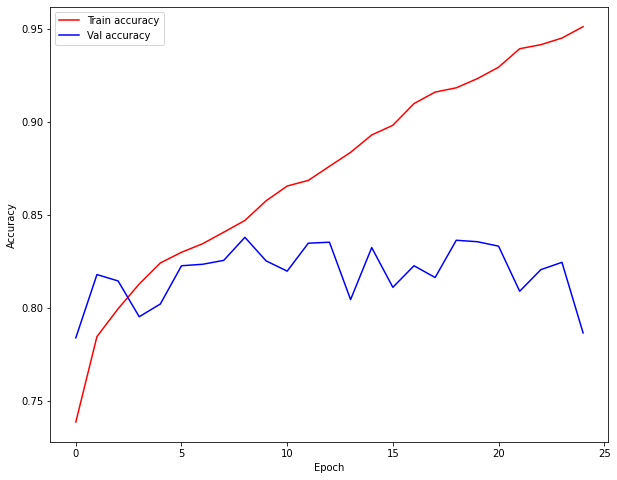

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m2],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m2],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


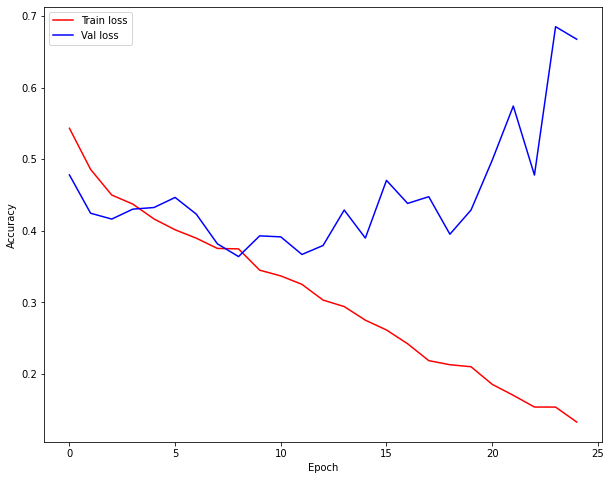

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m2,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m2,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pickle.dump(model_2, open(models_directory+'/second_model.sav', 'wb'))
pickle.dump(weights_m2, open(models_directory+'/weights_m2.sav', 'wb'))
pickle.dump(train_acc_m2, open(models_directory+'/train_acc_m2.sav', 'wb'))
pickle.dump(train_loss_m2, open(models_directory+'/train_loss_m2.sav', 'wb'))
pickle.dump(val_acc_m2, open(models_directory+'/val_acc_m2.sav', 'wb'))
pickle.dump(val_loss_m2, open(models_directory+'/val_loss_m2.sav', 'wb'))

# Model 3

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(weights=True)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 2)  # Final classification layer with 2 outputs
)

# Move the model to the device
model = model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

summary(model, input_size=(3,512,512), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]           9,408
       BatchNorm2d-2         [32, 64, 256, 256]             128
              ReLU-3         [32, 64, 256, 256]               0
         MaxPool2d-4         [32, 64, 128, 128]               0
            Conv2d-5         [32, 64, 128, 128]          36,864
       BatchNorm2d-6         [32, 64, 128, 128]             128
              ReLU-7         [32, 64, 128, 128]               0
            Conv2d-8         [32, 64, 128, 128]          36,864
       BatchNorm2d-9         [32, 64, 128, 128]             128
             ReLU-10         [32, 64, 128, 128]               0
       BasicBlock-11         [32, 64, 128, 128]               0
           Conv2d-12         [32, 64, 128, 128]          36,864
      BatchNorm2d-13         [32, 64, 128, 128]             128
             ReLU-14         [32, 64, 1

In [ ]:
model_4,weights_m4, train_acc_m4, train_loss_m4, val_acc_m4, val_loss_m4= train_model(model,dataloaders,criterion,optimizer, 25, False)

Epoch 1/25: 100%|██████████| 475/475 [05:01<00:00,  1.58it/s]


train Loss: 0.6832 , train Accuracy: 0.5628


Epoch 1/25: 100%|██████████| 119/119 [01:09<00:00,  1.71it/s]


val Loss: 0.6575 , val Accuracy: 0.6791
----------------------------------------------------------------------


Epoch 2/25: 100%|██████████| 475/475 [05:04<00:00,  1.56it/s]


train Loss: 0.6341 , train Accuracy: 0.6755


Epoch 2/25: 100%|██████████| 119/119 [01:09<00:00,  1.70it/s]


val Loss: 0.5904 , val Accuracy: 0.6970
----------------------------------------------------------------------


Epoch 3/25: 100%|██████████| 475/475 [05:03<00:00,  1.57it/s]


train Loss: 0.5607 , train Accuracy: 0.7324


Epoch 3/25: 100%|██████████| 119/119 [01:10<00:00,  1.69it/s]


val Loss: 0.5039 , val Accuracy: 0.7603
----------------------------------------------------------------------


Epoch 4/25: 100%|██████████| 475/475 [05:05<00:00,  1.55it/s]


train Loss: 0.4958 , train Accuracy: 0.7681


Epoch 4/25: 100%|██████████| 119/119 [01:10<00:00,  1.68it/s]


val Loss: 0.4546 , val Accuracy: 0.7864
----------------------------------------------------------------------


Epoch 5/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.4684 , train Accuracy: 0.7776


Epoch 5/25: 100%|██████████| 119/119 [01:11<00:00,  1.68it/s]


val Loss: 0.4362 , val Accuracy: 0.7964
----------------------------------------------------------------------


Epoch 6/25: 100%|██████████| 475/475 [05:00<00:00,  1.58it/s]


train Loss: 0.4529 , train Accuracy: 0.7889


Epoch 6/25: 100%|██████████| 119/119 [01:10<00:00,  1.68it/s]


val Loss: 0.4250 , val Accuracy: 0.7995
----------------------------------------------------------------------


Epoch 7/25: 100%|██████████| 475/475 [05:00<00:00,  1.58it/s]


train Loss: 0.4385 , train Accuracy: 0.7947


Epoch 7/25: 100%|██████████| 119/119 [01:10<00:00,  1.70it/s]


val Loss: 0.4158 , val Accuracy: 0.8103
----------------------------------------------------------------------


Epoch 8/25: 100%|██████████| 475/475 [05:04<00:00,  1.56it/s]


train Loss: 0.4270 , train Accuracy: 0.8018


Epoch 8/25: 100%|██████████| 119/119 [01:09<00:00,  1.71it/s]


val Loss: 0.4099 , val Accuracy: 0.8048
----------------------------------------------------------------------


Epoch 9/25: 100%|██████████| 475/475 [05:01<00:00,  1.57it/s]


train Loss: 0.4226 , train Accuracy: 0.8052


Epoch 9/25: 100%|██████████| 119/119 [01:09<00:00,  1.72it/s]


val Loss: 0.3986 , val Accuracy: 0.8180
----------------------------------------------------------------------


Epoch 10/25: 100%|██████████| 475/475 [05:00<00:00,  1.58it/s]


train Loss: 0.4122 , train Accuracy: 0.8126


Epoch 10/25: 100%|██████████| 119/119 [01:09<00:00,  1.71it/s]


val Loss: 0.3901 , val Accuracy: 0.8240
----------------------------------------------------------------------


Epoch 11/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.3986 , train Accuracy: 0.8209


Epoch 11/25: 100%|██████████| 119/119 [01:10<00:00,  1.69it/s]


val Loss: 0.3871 , val Accuracy: 0.8267
----------------------------------------------------------------------


Epoch 12/25: 100%|██████████| 475/475 [05:03<00:00,  1.57it/s]


train Loss: 0.3902 , train Accuracy: 0.8243


Epoch 12/25: 100%|██████████| 119/119 [01:09<00:00,  1.70it/s]


val Loss: 0.3808 , val Accuracy: 0.8301
----------------------------------------------------------------------


Epoch 13/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.3819 , train Accuracy: 0.8330


Epoch 13/25: 100%|██████████| 119/119 [01:09<00:00,  1.70it/s]


val Loss: 0.3741 , val Accuracy: 0.8335
----------------------------------------------------------------------


Epoch 14/25: 100%|██████████| 475/475 [05:04<00:00,  1.56it/s]


train Loss: 0.3715 , train Accuracy: 0.8372


Epoch 14/25: 100%|██████████| 119/119 [01:11<00:00,  1.68it/s]


val Loss: 0.3685 , val Accuracy: 0.8340
----------------------------------------------------------------------


Epoch 15/25: 100%|██████████| 475/475 [05:01<00:00,  1.58it/s]


train Loss: 0.3628 , train Accuracy: 0.8415


Epoch 15/25: 100%|██████████| 119/119 [01:10<00:00,  1.68it/s]


val Loss: 0.3612 , val Accuracy: 0.8443
----------------------------------------------------------------------


Epoch 16/25: 100%|██████████| 475/475 [05:01<00:00,  1.57it/s]


train Loss: 0.3538 , train Accuracy: 0.8472


Epoch 16/25: 100%|██████████| 119/119 [01:11<00:00,  1.67it/s]


val Loss: 0.3599 , val Accuracy: 0.8414
----------------------------------------------------------------------


Epoch 17/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.3469 , train Accuracy: 0.8484


Epoch 17/25: 100%|██████████| 119/119 [01:09<00:00,  1.71it/s]


val Loss: 0.3538 , val Accuracy: 0.8440
----------------------------------------------------------------------


Epoch 18/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.3384 , train Accuracy: 0.8540


Epoch 18/25: 100%|██████████| 119/119 [01:10<00:00,  1.69it/s]


val Loss: 0.3558 , val Accuracy: 0.8427
----------------------------------------------------------------------


Epoch 19/25: 100%|██████████| 475/475 [04:55<00:00,  1.61it/s]


train Loss: 0.3303 , train Accuracy: 0.8578


Epoch 19/25: 100%|██████████| 119/119 [01:10<00:00,  1.68it/s]


val Loss: 0.3488 , val Accuracy: 0.8498
----------------------------------------------------------------------


Epoch 20/25: 100%|██████████| 475/475 [05:00<00:00,  1.58it/s]


train Loss: 0.3164 , train Accuracy: 0.8675


Epoch 20/25: 100%|██████████| 119/119 [01:10<00:00,  1.68it/s]


val Loss: 0.3454 , val Accuracy: 0.8506
----------------------------------------------------------------------


Epoch 21/25: 100%|██████████| 475/475 [05:04<00:00,  1.56it/s]


train Loss: 0.3138 , train Accuracy: 0.8671


Epoch 21/25: 100%|██████████| 119/119 [01:10<00:00,  1.69it/s]


val Loss: 0.3408 , val Accuracy: 0.8585
----------------------------------------------------------------------


Epoch 22/25: 100%|██████████| 475/475 [05:03<00:00,  1.57it/s]


train Loss: 0.3007 , train Accuracy: 0.8740


Epoch 22/25: 100%|██████████| 119/119 [01:10<00:00,  1.70it/s]


val Loss: 0.3474 , val Accuracy: 0.8517
----------------------------------------------------------------------


Epoch 23/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.2875 , train Accuracy: 0.8813


Epoch 23/25: 100%|██████████| 119/119 [01:09<00:00,  1.72it/s]


val Loss: 0.3400 , val Accuracy: 0.8527
----------------------------------------------------------------------


Epoch 24/25: 100%|██████████| 475/475 [05:05<00:00,  1.56it/s]


train Loss: 0.2793 , train Accuracy: 0.8846


Epoch 24/25: 100%|██████████| 119/119 [01:09<00:00,  1.71it/s]


val Loss: 0.3349 , val Accuracy: 0.8599
----------------------------------------------------------------------


Epoch 25/25: 100%|██████████| 475/475 [05:02<00:00,  1.57it/s]


train Loss: 0.2672 , train Accuracy: 0.8933


Epoch 25/25: 100%|██████████| 119/119 [01:09<00:00,  1.70it/s]

val Loss: 0.3385 , val Accuracy: 0.8570
----------------------------------------------------------------------
Training complete in 155m 15s
Best val Acc: 0.859852


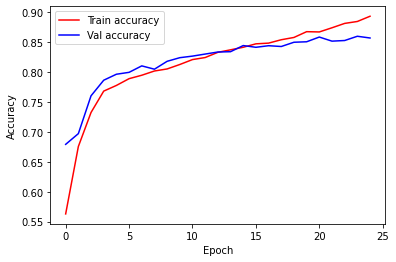

In [ ]:
n_epochs=25
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m4],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m4],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

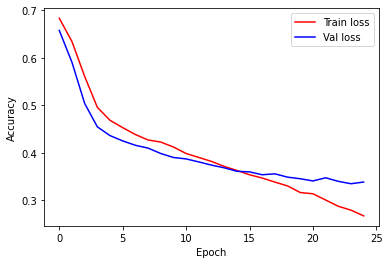

In [ ]:
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m4,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m4,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pickle.dump(model_4, open(models_directory+'/fourth_model.sav', 'wb'))
pickle.dump(weights_m4, open(models_directory+'/weights_m4.sav', 'wb'))
pickle.dump(train_acc_m4, open(models_directory+'/train_acc_m4.sav', 'wb'))
pickle.dump(train_loss_m4, open(models_directory+'/train_loss_m4.sav', 'wb'))
pickle.dump(val_acc_m4, open(models_directory+'/val_acc_m4.sav', 'wb'))
pickle.dump(val_loss_m4, open(models_directory+'/val_loss_m4.sav', 'wb'))

# Model 4

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model5 = torchvision.models.resnet18(weights=True)

ct=0
for child in model5.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model5.fc.in_features
model5.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.1), 
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.1), # Apply dropout to the output with a rate of 0.5
    nn.Linear(64, 2)  # Final classification layer with 2 outputs
)

# Move the model to the device
model5 = model5.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model5.parameters(), lr=0.0001, momentum=0.8)

summary(model5, input_size=(3,512,512), batch_size=64)

dataloaders= {'train':train_loader,'val': valid_loader}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 256, 256]           9,408
       BatchNorm2d-2         [64, 64, 256, 256]             128
              ReLU-3         [64, 64, 256, 256]               0
         MaxPool2d-4         [64, 64, 128, 128]               0
            Conv2d-5         [64, 64, 128, 128]          36,864
       BatchNorm2d-6         [64, 64, 128, 128]             128
              ReLU-7         [64, 64, 128, 128]               0
            Conv2d-8         [64, 64, 128, 128]          36,864
       BatchNorm2d-9         [64, 64, 128, 128]             128
             ReLU-10         [64, 64, 128, 128]               0
       BasicBlock-11         [64, 64, 128, 128]               0
           Conv2d-12         [64, 64, 128, 128]          36,864
      BatchNorm2d-13         [64, 64, 128, 128]             128
             ReLU-14         [64, 64, 1

In [ ]:
def dfs_freeze(model):
    for name, child in model.named_children():
        print(name)
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


# Model 5

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model6 = torchvision.models.resnet18(weights=True)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model6.fc.in_features
model6.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 2)  # Final classification layer with 2 outputs
)

# Move the model to the device
model6 = model6.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model6.parameters(), lr=0.001, momentum=0.8)

summary(model6, input_size=(3,224,224), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
model_6,weights_m6, train_acc_m6, train_loss_m6, val_acc_m6, val_loss_m6= train_model(model6,dataloaders,criterion,optimizer,50,False)

Epoch 1/50: 100%|██████████| 475/475 [03:12<00:00,  2.47it/s]


train Loss: 0.5530 , train Accuracy: 0.7135


Epoch 1/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.4268 , val Accuracy: 0.8087
----------------------------------------------------------------------


Epoch 2/50: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.4272 , train Accuracy: 0.8068


Epoch 2/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3859 , val Accuracy: 0.8298
----------------------------------------------------------------------


Epoch 3/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.3976 , train Accuracy: 0.8201


Epoch 3/50: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3741 , val Accuracy: 0.8343
----------------------------------------------------------------------


Epoch 4/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.3797 , train Accuracy: 0.8283


Epoch 4/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3624 , val Accuracy: 0.8356
----------------------------------------------------------------------


Epoch 5/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.3586 , train Accuracy: 0.8392


Epoch 5/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3479 , val Accuracy: 0.8427
----------------------------------------------------------------------


Epoch 6/50: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.3523 , train Accuracy: 0.8453


Epoch 6/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3412 , val Accuracy: 0.8509
----------------------------------------------------------------------


Epoch 7/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.3397 , train Accuracy: 0.8506


Epoch 7/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3356 , val Accuracy: 0.8491
----------------------------------------------------------------------


Epoch 8/50: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.3308 , train Accuracy: 0.8553


Epoch 8/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3264 , val Accuracy: 0.8570
----------------------------------------------------------------------


Epoch 9/50: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.3199 , train Accuracy: 0.8619


Epoch 9/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3246 , val Accuracy: 0.8554
----------------------------------------------------------------------


Epoch 10/50: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.3126 , train Accuracy: 0.8625


Epoch 10/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3247 , val Accuracy: 0.8577
----------------------------------------------------------------------


Epoch 11/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2995 , train Accuracy: 0.8713


Epoch 11/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3152 , val Accuracy: 0.8643
----------------------------------------------------------------------


Epoch 12/50: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.2918 , train Accuracy: 0.8733


Epoch 12/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3161 , val Accuracy: 0.8646
----------------------------------------------------------------------


Epoch 13/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2914 , train Accuracy: 0.8773


Epoch 13/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3151 , val Accuracy: 0.8630
----------------------------------------------------------------------


Epoch 14/50: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2824 , train Accuracy: 0.8804


Epoch 14/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3114 , val Accuracy: 0.8651
----------------------------------------------------------------------


Epoch 15/50: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.2719 , train Accuracy: 0.8842


Epoch 15/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3160 , val Accuracy: 0.8649
----------------------------------------------------------------------


Epoch 16/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2659 , train Accuracy: 0.8866


Epoch 16/50: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3209 , val Accuracy: 0.8633
----------------------------------------------------------------------


Epoch 17/50: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.2532 , train Accuracy: 0.8941


Epoch 17/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3225 , val Accuracy: 0.8641
----------------------------------------------------------------------


Epoch 18/50: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2547 , train Accuracy: 0.8927


Epoch 18/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3164 , val Accuracy: 0.8691
----------------------------------------------------------------------


Epoch 19/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2496 , train Accuracy: 0.8946


Epoch 19/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3253 , val Accuracy: 0.8707
----------------------------------------------------------------------


Epoch 20/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2402 , train Accuracy: 0.8979


Epoch 20/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3035 , val Accuracy: 0.8712
----------------------------------------------------------------------


Epoch 21/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2348 , train Accuracy: 0.9025


Epoch 21/50: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3117 , val Accuracy: 0.8683
----------------------------------------------------------------------


Epoch 22/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2332 , train Accuracy: 0.9023


Epoch 22/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3012 , val Accuracy: 0.8751
----------------------------------------------------------------------


Epoch 23/50: 100%|██████████| 475/475 [03:11<00:00,  2.49it/s]


train Loss: 0.2275 , train Accuracy: 0.9054


Epoch 23/50: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3120 , val Accuracy: 0.8733
----------------------------------------------------------------------


Epoch 24/50: 100%|██████████| 475/475 [03:12<00:00,  2.47it/s]


train Loss: 0.2183 , train Accuracy: 0.9100


Epoch 24/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3047 , val Accuracy: 0.8712
----------------------------------------------------------------------


Epoch 25/50: 100%|██████████| 475/475 [03:13<00:00,  2.46it/s]


train Loss: 0.2167 , train Accuracy: 0.9098


Epoch 25/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.2982 , val Accuracy: 0.8778
----------------------------------------------------------------------


Epoch 26/50: 100%|██████████| 475/475 [03:11<00:00,  2.48it/s]


train Loss: 0.2149 , train Accuracy: 0.9094


Epoch 26/50: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.2920 , val Accuracy: 0.8799
----------------------------------------------------------------------


Epoch 27/50: 100%|██████████| 475/475 [03:13<00:00,  2.45it/s]


train Loss: 0.2052 , train Accuracy: 0.9158


Epoch 27/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3202 , val Accuracy: 0.8701
----------------------------------------------------------------------


Epoch 28/50: 100%|██████████| 475/475 [03:14<00:00,  2.44it/s]


train Loss: 0.2009 , train Accuracy: 0.9164


Epoch 28/50: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.3008 , val Accuracy: 0.8801
----------------------------------------------------------------------


Epoch 29/50: 100%|██████████| 475/475 [03:11<00:00,  2.49it/s]


train Loss: 0.1952 , train Accuracy: 0.9188


Epoch 29/50: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.3117 , val Accuracy: 0.8722
----------------------------------------------------------------------


Epoch 30/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1927 , train Accuracy: 0.9235


Epoch 30/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3064 , val Accuracy: 0.8751
----------------------------------------------------------------------


Epoch 31/50: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.1843 , train Accuracy: 0.9243


Epoch 31/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3098 , val Accuracy: 0.8793
----------------------------------------------------------------------


Epoch 32/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1802 , train Accuracy: 0.9276


Epoch 32/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3046 , val Accuracy: 0.8815
----------------------------------------------------------------------


Epoch 33/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1745 , train Accuracy: 0.9306


Epoch 33/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3243 , val Accuracy: 0.8783
----------------------------------------------------------------------


Epoch 34/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1741 , train Accuracy: 0.9282


Epoch 34/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3290 , val Accuracy: 0.8746
----------------------------------------------------------------------


Epoch 35/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1698 , train Accuracy: 0.9300


Epoch 35/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3249 , val Accuracy: 0.8783
----------------------------------------------------------------------


Epoch 36/50: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.1630 , train Accuracy: 0.9342


Epoch 36/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3206 , val Accuracy: 0.8799
----------------------------------------------------------------------


Epoch 37/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1607 , train Accuracy: 0.9345


Epoch 37/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3173 , val Accuracy: 0.8778
----------------------------------------------------------------------


Epoch 38/50: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.1555 , train Accuracy: 0.9366


Epoch 38/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3353 , val Accuracy: 0.8746
----------------------------------------------------------------------


Epoch 39/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1607 , train Accuracy: 0.9356


Epoch 39/50: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3368 , val Accuracy: 0.8751
----------------------------------------------------------------------


Epoch 40/50: 100%|██████████| 475/475 [03:11<00:00,  2.48it/s]


train Loss: 0.1456 , train Accuracy: 0.9410


Epoch 40/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3389 , val Accuracy: 0.8838
----------------------------------------------------------------------


Epoch 41/50: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.1433 , train Accuracy: 0.9427


Epoch 41/50: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3362 , val Accuracy: 0.8741
----------------------------------------------------------------------


Epoch 42/50: 100%|██████████| 475/475 [03:10<00:00,  2.49it/s]


train Loss: 0.1443 , train Accuracy: 0.9442


Epoch 42/50: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.3264 , val Accuracy: 0.8857
----------------------------------------------------------------------


Epoch 43/50: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.1354 , train Accuracy: 0.9460


Epoch 43/50: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3500 , val Accuracy: 0.8780
----------------------------------------------------------------------


Epoch 44/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1332 , train Accuracy: 0.9466


Epoch 44/50: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3424 , val Accuracy: 0.8851
----------------------------------------------------------------------


Epoch 45/50: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.1283 , train Accuracy: 0.9497


Epoch 45/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3524 , val Accuracy: 0.8799
----------------------------------------------------------------------


Epoch 46/50: 100%|██████████| 475/475 [03:10<00:00,  2.49it/s]


train Loss: 0.1275 , train Accuracy: 0.9496


Epoch 46/50: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3283 , val Accuracy: 0.8891
----------------------------------------------------------------------


Epoch 47/50: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.1225 , train Accuracy: 0.9518


Epoch 47/50: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.3370 , val Accuracy: 0.8841
----------------------------------------------------------------------


Epoch 48/50: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.1283 , train Accuracy: 0.9487


Epoch 48/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3538 , val Accuracy: 0.8854
----------------------------------------------------------------------


Epoch 49/50: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.1179 , train Accuracy: 0.9549


Epoch 49/50: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3601 , val Accuracy: 0.8838
----------------------------------------------------------------------


Epoch 50/50: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.1142 , train Accuracy: 0.9552


Epoch 50/50: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]

val Loss: 0.3587 , val Accuracy: 0.8815
----------------------------------------------------------------------
Training complete in 197m 3s
Best val Acc: 0.889094


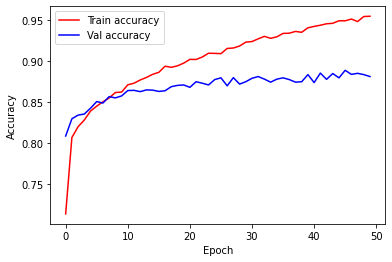

In [ ]:
n_epochs=50
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m6],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m6],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

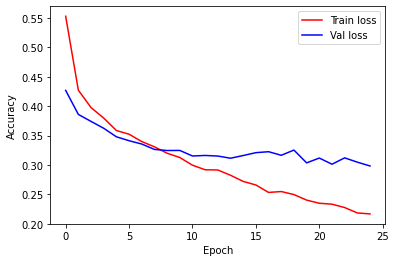

In [ ]:
plt.plot(range(n_epochs-25), train_loss_m6[:25],'r',label='Train loss')
plt.plot(range(n_epochs-25), val_loss_m6[:25],'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pickle.dump(model_6, open(models_directory+'/sixth_model.sav', 'wb'))
pickle.dump(weights_m6, open(models_directory+'/weights_m6.sav', 'wb'))
pickle.dump(train_acc_m6, open(models_directory+'/train_acc_m6.sav', 'wb'))
pickle.dump(train_loss_m6, open(models_directory+'/train_loss_m6.sav', 'wb'))
pickle.dump(val_acc_m6, open(models_directory+'/val_acc_m6.sav', 'wb'))
pickle.dump(val_loss_m6, open(models_directory+'/val_loss_m6.sav', 'wb'))

# Model 6

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model7 = torchvision.models.resnet18(weights=True)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model7.fc.in_features
model7.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 2)  # Final classification layer with 2 outputs
)

# Move the model to the device
model7 = model7.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model7.parameters(), lr=0.001, momentum=0.8)

summary(model7, input_size=(3,224,224), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
model_7,weights_m7, train_acc_m7, train_loss_m7, val_acc_m7, val_loss_m7= train_model(model7,dataloaders,criterion,optimizer,30,False)

Epoch 1/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.5519 , train Accuracy: 0.7279


Epoch 1/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.4243 , val Accuracy: 0.8061
----------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 475/475 [03:07<00:00,  2.54it/s]


train Loss: 0.4231 , train Accuracy: 0.8076


Epoch 2/30: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3877 , val Accuracy: 0.8227
----------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.3976 , train Accuracy: 0.8218


Epoch 3/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3684 , val Accuracy: 0.8369
----------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.3726 , train Accuracy: 0.8340


Epoch 4/30: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3548 , val Accuracy: 0.8435
----------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 475/475 [03:09<00:00,  2.50it/s]


train Loss: 0.3589 , train Accuracy: 0.8452


Epoch 5/30: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3455 , val Accuracy: 0.8475
----------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 475/475 [03:10<00:00,  2.49it/s]


train Loss: 0.3468 , train Accuracy: 0.8487


Epoch 6/30: 100%|██████████| 119/119 [00:46<00:00,  2.59it/s]


val Loss: 0.3454 , val Accuracy: 0.8475
----------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.3384 , train Accuracy: 0.8532


Epoch 7/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3344 , val Accuracy: 0.8543
----------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.3232 , train Accuracy: 0.8601


Epoch 8/30: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3294 , val Accuracy: 0.8556
----------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.3151 , train Accuracy: 0.8627


Epoch 9/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3274 , val Accuracy: 0.8554
----------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.3112 , train Accuracy: 0.8656


Epoch 10/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3165 , val Accuracy: 0.8614
----------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.3033 , train Accuracy: 0.8696


Epoch 11/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3235 , val Accuracy: 0.8617
----------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 475/475 [03:08<00:00,  2.51it/s]


train Loss: 0.2903 , train Accuracy: 0.8802


Epoch 12/30: 100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


val Loss: 0.3151 , val Accuracy: 0.8609
----------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2894 , train Accuracy: 0.8777


Epoch 13/30: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3157 , val Accuracy: 0.8596
----------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.2787 , train Accuracy: 0.8808


Epoch 14/30: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.3112 , val Accuracy: 0.8667
----------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 475/475 [03:07<00:00,  2.54it/s]


train Loss: 0.2713 , train Accuracy: 0.8863


Epoch 15/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3240 , val Accuracy: 0.8596
----------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.2653 , train Accuracy: 0.8883


Epoch 16/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3111 , val Accuracy: 0.8672
----------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2550 , train Accuracy: 0.8929


Epoch 17/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3153 , val Accuracy: 0.8709
----------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 475/475 [03:06<00:00,  2.55it/s]


train Loss: 0.2511 , train Accuracy: 0.8942


Epoch 18/30: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.2973 , val Accuracy: 0.8775
----------------------------------------------------------------------


Epoch 19/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.2483 , train Accuracy: 0.8946


Epoch 19/30: 100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


val Loss: 0.3117 , val Accuracy: 0.8699
----------------------------------------------------------------------


Epoch 20/30: 100%|██████████| 475/475 [03:06<00:00,  2.54it/s]


train Loss: 0.2384 , train Accuracy: 0.9001


Epoch 20/30: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3080 , val Accuracy: 0.8733
----------------------------------------------------------------------


Epoch 21/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2337 , train Accuracy: 0.9040


Epoch 21/30: 100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


val Loss: 0.3207 , val Accuracy: 0.8683
----------------------------------------------------------------------


Epoch 22/30: 100%|██████████| 475/475 [03:07<00:00,  2.54it/s]


train Loss: 0.2337 , train Accuracy: 0.9033


Epoch 22/30: 100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


val Loss: 0.3029 , val Accuracy: 0.8754
----------------------------------------------------------------------


Epoch 23/30: 100%|██████████| 475/475 [03:06<00:00,  2.54it/s]


train Loss: 0.2236 , train Accuracy: 0.9076


Epoch 23/30: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3322 , val Accuracy: 0.8696
----------------------------------------------------------------------


Epoch 24/30: 100%|██████████| 475/475 [03:07<00:00,  2.53it/s]


train Loss: 0.2209 , train Accuracy: 0.9084


Epoch 24/30: 100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


val Loss: 0.3066 , val Accuracy: 0.8728
----------------------------------------------------------------------


Epoch 25/30: 100%|██████████| 475/475 [03:09<00:00,  2.51it/s]


train Loss: 0.2139 , train Accuracy: 0.9106


Epoch 25/30: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.2983 , val Accuracy: 0.8793
----------------------------------------------------------------------


Epoch 26/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2094 , train Accuracy: 0.9121


Epoch 26/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3153 , val Accuracy: 0.8717
----------------------------------------------------------------------


Epoch 27/30: 100%|██████████| 475/475 [03:08<00:00,  2.52it/s]


train Loss: 0.2019 , train Accuracy: 0.9189


Epoch 27/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3194 , val Accuracy: 0.8712
----------------------------------------------------------------------


Epoch 28/30: 100%|██████████| 475/475 [03:10<00:00,  2.50it/s]


train Loss: 0.2013 , train Accuracy: 0.9194


Epoch 28/30: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3192 , val Accuracy: 0.8730
----------------------------------------------------------------------


Epoch 29/30: 100%|██████████| 475/475 [03:12<00:00,  2.47it/s]


train Loss: 0.1961 , train Accuracy: 0.9209


Epoch 29/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3127 , val Accuracy: 0.8799
----------------------------------------------------------------------


Epoch 30/30: 100%|██████████| 475/475 [03:13<00:00,  2.46it/s]


train Loss: 0.1948 , train Accuracy: 0.9215


Epoch 30/30: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]

val Loss: 0.3318 , val Accuracy: 0.8762
----------------------------------------------------------------------
Training complete in 117m 24s
Best val Acc: 0.879874


In [ ]:
pickle.dump(model_7, open(models_directory+'/seventh_model.sav', 'wb'))
pickle.dump(weights_m7, open(models_directory+'/weights_m7.sav', 'wb'))
pickle.dump(train_acc_m7, open(models_directory+'/train_acc_m7.sav', 'wb'))
pickle.dump(train_loss_m7, open(models_directory+'/train_loss_m7.sav', 'wb'))
pickle.dump(val_acc_m7, open(models_directory+'/val_acc_m7.sav', 'wb'))
pickle.dump(val_loss_m7, open(models_directory+'/val_loss_m7.sav', 'wb'))

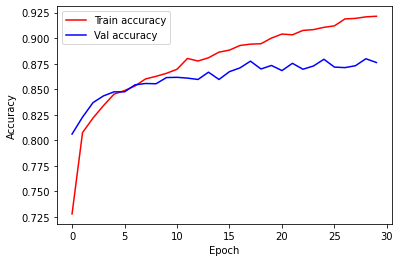

In [ ]:
n_epochs=30
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m7],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m7],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

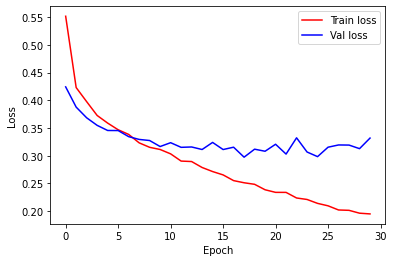

In [ ]:
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m7,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m7,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 7

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model8 = torchvision.models.efficientnet_b0(weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT)


# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model8.classifier[1].in_features
model8.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs,512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 2)  # Final classification layer with 2 outputs
)

# Move the model to the device
model8 = model8.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model8.parameters(), lr=0.0001)

summary(model8, input_size=(3,224,224), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [ ]:
model_8,weights_m8, train_acc_m8, train_loss_m8, val_acc_m8, val_loss_m8= train_model(model8,dataloaders,criterion,optimizer,30,False)

Epoch 1/30: 100%|██████████| 475/475 [03:20<00:00,  2.37it/s]


train Loss: 0.4368 , train Accuracy: 0.8004


Epoch 1/30: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.4057 , val Accuracy: 0.8309
----------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.3372 , train Accuracy: 0.8584


Epoch 2/30: 100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


val Loss: 0.3246 , val Accuracy: 0.8591
----------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.3004 , train Accuracy: 0.8701


Epoch 3/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3127 , val Accuracy: 0.8638
----------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.2767 , train Accuracy: 0.8829


Epoch 4/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.2993 , val Accuracy: 0.8717
----------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 475/475 [03:20<00:00,  2.37it/s]


train Loss: 0.2521 , train Accuracy: 0.8950


Epoch 5/30: 100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


val Loss: 0.2908 , val Accuracy: 0.8743
----------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.2348 , train Accuracy: 0.9027


Epoch 6/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3092 , val Accuracy: 0.8667
----------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.2132 , train Accuracy: 0.9123


Epoch 7/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.2921 , val Accuracy: 0.8812
----------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.2004 , train Accuracy: 0.9171


Epoch 8/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.2908 , val Accuracy: 0.8817
----------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.1797 , train Accuracy: 0.9250


Epoch 9/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.2930 , val Accuracy: 0.8878
----------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1657 , train Accuracy: 0.9337


Epoch 10/30: 100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


val Loss: 0.3036 , val Accuracy: 0.8846
----------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.1579 , train Accuracy: 0.9346


Epoch 11/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3021 , val Accuracy: 0.8928
----------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.1482 , train Accuracy: 0.9425


Epoch 12/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.2928 , val Accuracy: 0.8933
----------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.1328 , train Accuracy: 0.9474


Epoch 13/30: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.3129 , val Accuracy: 0.8957
----------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1220 , train Accuracy: 0.9515


Epoch 14/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3151 , val Accuracy: 0.8967
----------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1145 , train Accuracy: 0.9555


Epoch 15/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3255 , val Accuracy: 0.8986
----------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 475/475 [03:24<00:00,  2.32it/s]


train Loss: 0.1083 , train Accuracy: 0.9601


Epoch 16/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3245 , val Accuracy: 0.8933
----------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 475/475 [03:19<00:00,  2.38it/s]


train Loss: 0.1022 , train Accuracy: 0.9620


Epoch 17/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3254 , val Accuracy: 0.8970
----------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.0919 , train Accuracy: 0.9643


Epoch 18/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3507 , val Accuracy: 0.8996
----------------------------------------------------------------------


Epoch 19/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0855 , train Accuracy: 0.9664


Epoch 19/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3628 , val Accuracy: 0.8967
----------------------------------------------------------------------


Epoch 20/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0809 , train Accuracy: 0.9693


Epoch 20/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3513 , val Accuracy: 0.8988
----------------------------------------------------------------------


Epoch 21/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0850 , train Accuracy: 0.9687


Epoch 21/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3312 , val Accuracy: 0.9052
----------------------------------------------------------------------


Epoch 22/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.0743 , train Accuracy: 0.9725


Epoch 22/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3337 , val Accuracy: 0.9062
----------------------------------------------------------------------


Epoch 23/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0681 , train Accuracy: 0.9743


Epoch 23/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3468 , val Accuracy: 0.9004
----------------------------------------------------------------------


Epoch 24/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.0684 , train Accuracy: 0.9733


Epoch 24/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3477 , val Accuracy: 0.8988
----------------------------------------------------------------------


Epoch 25/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.0667 , train Accuracy: 0.9755


Epoch 25/30: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.3907 , val Accuracy: 0.8983
----------------------------------------------------------------------


Epoch 26/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0607 , train Accuracy: 0.9770


Epoch 26/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3994 , val Accuracy: 0.9036
----------------------------------------------------------------------


Epoch 27/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.0609 , train Accuracy: 0.9789


Epoch 27/30: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.3683 , val Accuracy: 0.9012
----------------------------------------------------------------------


Epoch 28/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0597 , train Accuracy: 0.9787


Epoch 28/30: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.3836 , val Accuracy: 0.8986
----------------------------------------------------------------------


Epoch 29/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.0569 , train Accuracy: 0.9798


Epoch 29/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3512 , val Accuracy: 0.9009
----------------------------------------------------------------------


Epoch 30/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.0552 , train Accuracy: 0.9797


Epoch 30/30: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]

val Loss: 0.3664 , val Accuracy: 0.9067
----------------------------------------------------------------------
Training complete in 122m 45s
Best val Acc: 0.906744


In [ ]:
model_8,weights_m8, train_acc_m8, train_loss_m8, val_acc_m8, val_loss_m8= train_model(model8,dataloaders,criterion,optimizer,30,False)

Epoch 1/30: 100%|██████████| 475/475 [46:25<00:00,  5.86s/it]


train Loss: 0.4342 , train Accuracy: 0.7951


Epoch 1/30: 100%|██████████| 119/119 [20:46<00:00, 10.48s/it]


val Loss: 0.3458 , val Accuracy: 0.8469
----------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 475/475 [03:24<00:00,  2.32it/s]


train Loss: 0.3362 , train Accuracy: 0.8553


Epoch 2/30: 100%|██████████| 119/119 [00:48<00:00,  2.43it/s]


val Loss: 0.3233 , val Accuracy: 0.8635
----------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 475/475 [03:20<00:00,  2.37it/s]


train Loss: 0.3042 , train Accuracy: 0.8717


Epoch 3/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3054 , val Accuracy: 0.8696
----------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 475/475 [03:20<00:00,  2.37it/s]


train Loss: 0.2799 , train Accuracy: 0.8843


Epoch 4/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.2987 , val Accuracy: 0.8733
----------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 475/475 [03:21<00:00,  2.36it/s]


train Loss: 0.2519 , train Accuracy: 0.8929


Epoch 5/30: 100%|██████████| 119/119 [00:48<00:00,  2.43it/s]


val Loss: 0.2836 , val Accuracy: 0.8804
----------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 475/475 [03:22<00:00,  2.35it/s]


train Loss: 0.2285 , train Accuracy: 0.9062


Epoch 6/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.2938 , val Accuracy: 0.8833
----------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.2099 , train Accuracy: 0.9127


Epoch 7/30: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.2903 , val Accuracy: 0.8825
----------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1990 , train Accuracy: 0.9169


Epoch 8/30: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.2979 , val Accuracy: 0.8775
----------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1851 , train Accuracy: 0.9226


Epoch 9/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.2950 , val Accuracy: 0.8870
----------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.1652 , train Accuracy: 0.9350


Epoch 10/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.2845 , val Accuracy: 0.8836
----------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.1518 , train Accuracy: 0.9385


Epoch 11/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3101 , val Accuracy: 0.8859
----------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.1409 , train Accuracy: 0.9433


Epoch 12/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3039 , val Accuracy: 0.8896
----------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.1316 , train Accuracy: 0.9487


Epoch 13/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3093 , val Accuracy: 0.8886
----------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.1198 , train Accuracy: 0.9529


Epoch 14/30: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.3238 , val Accuracy: 0.8865
----------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.1106 , train Accuracy: 0.9573


Epoch 15/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3339 , val Accuracy: 0.8923
----------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.1076 , train Accuracy: 0.9572


Epoch 16/30: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.3327 , val Accuracy: 0.8928
----------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 475/475 [03:20<00:00,  2.36it/s]


train Loss: 0.1017 , train Accuracy: 0.9621


Epoch 17/30: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


val Loss: 0.3345 , val Accuracy: 0.8901
----------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 475/475 [03:19<00:00,  2.39it/s]


train Loss: 0.0922 , train Accuracy: 0.9647


Epoch 18/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3533 , val Accuracy: 0.8904
----------------------------------------------------------------------


Epoch 19/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0865 , train Accuracy: 0.9682


Epoch 19/30: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3610 , val Accuracy: 0.8952
----------------------------------------------------------------------


Epoch 20/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0814 , train Accuracy: 0.9694


Epoch 20/30: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3698 , val Accuracy: 0.8901
----------------------------------------------------------------------


Epoch 21/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0755 , train Accuracy: 0.9700


Epoch 21/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3722 , val Accuracy: 0.9009
----------------------------------------------------------------------


Epoch 22/30: 100%|██████████| 475/475 [03:15<00:00,  2.43it/s]


train Loss: 0.0778 , train Accuracy: 0.9713


Epoch 22/30: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.3716 , val Accuracy: 0.8915
----------------------------------------------------------------------


Epoch 23/30: 100%|██████████| 475/475 [03:15<00:00,  2.44it/s]


train Loss: 0.0650 , train Accuracy: 0.9767


Epoch 23/30: 100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


val Loss: 0.3932 , val Accuracy: 0.9028
----------------------------------------------------------------------


Epoch 24/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0703 , train Accuracy: 0.9735


Epoch 24/30: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.3840 , val Accuracy: 0.8946
----------------------------------------------------------------------


Epoch 25/30: 100%|██████████| 475/475 [03:15<00:00,  2.43it/s]


train Loss: 0.0602 , train Accuracy: 0.9778


Epoch 25/30: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3869 , val Accuracy: 0.8896
----------------------------------------------------------------------


Epoch 26/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0622 , train Accuracy: 0.9776


Epoch 26/30: 100%|██████████| 119/119 [00:46<00:00,  2.59it/s]


val Loss: 0.3885 , val Accuracy: 0.8983
----------------------------------------------------------------------


Epoch 27/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0595 , train Accuracy: 0.9774


Epoch 27/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.4287 , val Accuracy: 0.8973
----------------------------------------------------------------------


Epoch 28/30: 100%|██████████| 475/475 [03:19<00:00,  2.38it/s]


train Loss: 0.0493 , train Accuracy: 0.9826


Epoch 28/30: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.4143 , val Accuracy: 0.8999
----------------------------------------------------------------------


Epoch 29/30: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.0563 , train Accuracy: 0.9803


Epoch 29/30: 100%|██████████| 119/119 [00:46<00:00,  2.58it/s]


val Loss: 0.4171 , val Accuracy: 0.8973
----------------------------------------------------------------------


Epoch 30/30: 100%|██████████| 475/475 [03:16<00:00,  2.42it/s]


train Loss: 0.0509 , train Accuracy: 0.9819


Epoch 30/30: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]

val Loss: 0.4396 , val Accuracy: 0.9023
----------------------------------------------------------------------
Training complete in 185m 46s
Best val Acc: 0.902792


In [ ]:
pickle.dump(model_8, open(models_directory+'/eigth_model.sav', 'wb'))
pickle.dump(weights_m8, open(models_directory+'/weights_m8.sav', 'wb'))
pickle.dump(train_acc_m8, open(models_directory+'/train_acc_m8.sav', 'wb'))
pickle.dump(train_loss_m8, open(models_directory+'/train_loss_m8.sav', 'wb'))
pickle.dump(val_acc_m8, open(models_directory+'/val_acc_m8.sav', 'wb'))
pickle.dump(val_loss_m8, open(models_directory+'/val_loss_m8.sav', 'wb'))

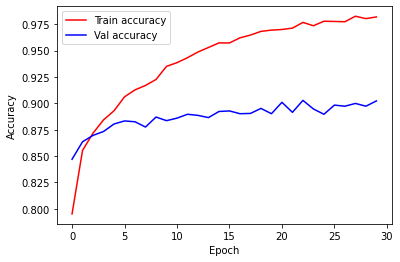

In [ ]:
n_epochs=30
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m8],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m8],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

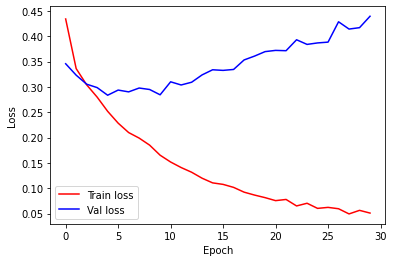

In [ ]:
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m8,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m8,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 8

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model9 = torchvision.models.efficientnet_b3(weights= torchvision.models.EfficientNet_B3_Weights.DEFAULT)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model9.classifier[1].in_features
model9.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs,512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # Apply dropout to the output with a rate of 0.5
    nn.Linear(128, 2)  # Final classification layer with 2 outputs
)

#ct=0
#for child in model9.children():
#  ct += 1
#  if ct < 2:
#    for param in child.parameters():
#      param.requires_grad = False
# Move the model to the device
model9 = model9.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model9.parameters(),lr=0.001)
optimizer = optim.Adam(model9.parameters(), lr=0.0001)

summary(model9, input_size=(3,224,224), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 40, 112, 112]           1,080
       BatchNorm2d-2         [32, 40, 112, 112]              80
              SiLU-3         [32, 40, 112, 112]               0
            Conv2d-4         [32, 40, 112, 112]             360
       BatchNorm2d-5         [32, 40, 112, 112]              80
              SiLU-6         [32, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 40, 1, 1]               0
            Conv2d-8             [32, 10, 1, 1]             410
              SiLU-9             [32, 10, 1, 1]               0
           Conv2d-10             [32, 40, 1, 1]             440
          Sigmoid-11             [32, 40, 1, 1]               0
SqueezeExcitation-12         [32, 40, 112, 112]               0
           Conv2d-13         [32, 24, 112, 112]             960
      BatchNorm2d-14         [32, 24, 1

In [ ]:
model_9,weights_m9, train_acc_m9, train_loss_m9, val_acc_m9, val_loss_m9= train_model(model9,dataloaders,criterion,optimizer,30,False)

Epoch 1/30: 100%|██████████| 475/475 [03:32<00:00,  2.23it/s]


train Loss: 0.4428 , train Accuracy: 0.7974


Epoch 1/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.3437 , val Accuracy: 0.8504
----------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 475/475 [03:32<00:00,  2.24it/s]


train Loss: 0.3407 , train Accuracy: 0.8525


Epoch 2/30: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.3113 , val Accuracy: 0.8656
----------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 475/475 [03:34<00:00,  2.22it/s]


train Loss: 0.3042 , train Accuracy: 0.8721


Epoch 3/30: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.2985 , val Accuracy: 0.8764
----------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 475/475 [03:32<00:00,  2.23it/s]


train Loss: 0.2729 , train Accuracy: 0.8820


Epoch 4/30: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]


val Loss: 0.3033 , val Accuracy: 0.8764
----------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 475/475 [03:34<00:00,  2.22it/s]


train Loss: 0.2477 , train Accuracy: 0.8957


Epoch 5/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.2897 , val Accuracy: 0.8780
----------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 475/475 [03:32<00:00,  2.24it/s]


train Loss: 0.2263 , train Accuracy: 0.9069


Epoch 6/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.2742 , val Accuracy: 0.8838
----------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 475/475 [03:33<00:00,  2.23it/s]


train Loss: 0.1973 , train Accuracy: 0.9204


Epoch 7/30: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]


val Loss: 0.2918 , val Accuracy: 0.8833
----------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 475/475 [03:34<00:00,  2.22it/s]


train Loss: 0.1794 , train Accuracy: 0.9261


Epoch 8/30: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]


val Loss: 0.2909 , val Accuracy: 0.8909
----------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 475/475 [03:33<00:00,  2.22it/s]


train Loss: 0.1724 , train Accuracy: 0.9295


Epoch 9/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.3069 , val Accuracy: 0.8867
----------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 475/475 [03:34<00:00,  2.22it/s]


train Loss: 0.1574 , train Accuracy: 0.9366


Epoch 10/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.2970 , val Accuracy: 0.8867
----------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 475/475 [03:32<00:00,  2.23it/s]


train Loss: 0.1363 , train Accuracy: 0.9477


Epoch 11/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.3389 , val Accuracy: 0.8941
----------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 475/475 [03:33<00:00,  2.22it/s]


train Loss: 0.1282 , train Accuracy: 0.9497


Epoch 12/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.3195 , val Accuracy: 0.8915
----------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 475/475 [03:33<00:00,  2.22it/s]


train Loss: 0.1090 , train Accuracy: 0.9577


Epoch 13/30: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.3467 , val Accuracy: 0.8967
----------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 475/475 [03:36<00:00,  2.20it/s]


train Loss: 0.1031 , train Accuracy: 0.9599


Epoch 14/30: 100%|██████████| 119/119 [00:49<00:00,  2.42it/s]


val Loss: 0.3730 , val Accuracy: 0.8844
----------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 475/475 [03:34<00:00,  2.21it/s]


train Loss: 0.1016 , train Accuracy: 0.9613


Epoch 15/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.3207 , val Accuracy: 0.8986
----------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 475/475 [03:36<00:00,  2.20it/s]


train Loss: 0.0876 , train Accuracy: 0.9660


Epoch 16/30: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


val Loss: 0.3539 , val Accuracy: 0.9028
----------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 475/475 [03:36<00:00,  2.20it/s]


train Loss: 0.0820 , train Accuracy: 0.9694


Epoch 17/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.3641 , val Accuracy: 0.8959
----------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 475/475 [03:36<00:00,  2.20it/s]


train Loss: 0.0745 , train Accuracy: 0.9706


Epoch 18/30: 100%|██████████| 119/119 [00:49<00:00,  2.42it/s]


val Loss: 0.3913 , val Accuracy: 0.8959
----------------------------------------------------------------------


Epoch 19/30: 100%|██████████| 475/475 [03:34<00:00,  2.21it/s]


train Loss: 0.0763 , train Accuracy: 0.9712


Epoch 19/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.4001 , val Accuracy: 0.8923
----------------------------------------------------------------------


Epoch 20/30: 100%|██████████| 475/475 [03:35<00:00,  2.20it/s]


train Loss: 0.0651 , train Accuracy: 0.9759


Epoch 20/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.4094 , val Accuracy: 0.8896
----------------------------------------------------------------------


Epoch 21/30: 100%|██████████| 475/475 [03:33<00:00,  2.23it/s]


train Loss: 0.0655 , train Accuracy: 0.9771


Epoch 21/30: 100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


val Loss: 0.3597 , val Accuracy: 0.8994
----------------------------------------------------------------------


Epoch 22/30: 100%|██████████| 475/475 [03:32<00:00,  2.23it/s]


train Loss: 0.0639 , train Accuracy: 0.9768


Epoch 22/30: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


val Loss: 0.3122 , val Accuracy: 0.9038
----------------------------------------------------------------------


Epoch 23/30: 100%|██████████| 475/475 [03:33<00:00,  2.23it/s]


train Loss: 0.0535 , train Accuracy: 0.9810


Epoch 23/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.4025 , val Accuracy: 0.8999
----------------------------------------------------------------------


Epoch 24/30: 100%|██████████| 475/475 [03:32<00:00,  2.23it/s]


train Loss: 0.0572 , train Accuracy: 0.9789


Epoch 24/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.3595 , val Accuracy: 0.8994
----------------------------------------------------------------------


Epoch 25/30: 100%|██████████| 475/475 [03:33<00:00,  2.22it/s]


train Loss: 0.0518 , train Accuracy: 0.9818


Epoch 25/30: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


val Loss: 0.4023 , val Accuracy: 0.9017
----------------------------------------------------------------------


Epoch 26/30: 100%|██████████| 475/475 [03:35<00:00,  2.20it/s]


train Loss: 0.0484 , train Accuracy: 0.9810


Epoch 26/30: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]


val Loss: 0.4464 , val Accuracy: 0.9089
----------------------------------------------------------------------


Epoch 27/30: 100%|██████████| 475/475 [03:34<00:00,  2.22it/s]


train Loss: 0.0481 , train Accuracy: 0.9826


Epoch 27/30: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


val Loss: 0.4008 , val Accuracy: 0.9096
----------------------------------------------------------------------


Epoch 28/30: 100%|██████████| 475/475 [03:35<00:00,  2.21it/s]


train Loss: 0.0401 , train Accuracy: 0.9852


Epoch 28/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.3898 , val Accuracy: 0.9057
----------------------------------------------------------------------


Epoch 29/30: 100%|██████████| 475/475 [03:34<00:00,  2.21it/s]


train Loss: 0.0422 , train Accuracy: 0.9862


Epoch 29/30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


val Loss: 0.3936 , val Accuracy: 0.9009
----------------------------------------------------------------------


Epoch 30/30: 100%|██████████| 475/475 [03:34<00:00,  2.21it/s]


train Loss: 0.0396 , train Accuracy: 0.9864


Epoch 30/30: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]

val Loss: 0.4058 , val Accuracy: 0.9057
----------------------------------------------------------------------
Training complete in 131m 12s
Best val Acc: 0.909642


In [ ]:
pickle.dump(model_9, open(models_directory+'/ninth_model.sav', 'wb'))
pickle.dump(weights_m9, open(models_directory+'/weights_m9.sav', 'wb'))
pickle.dump(train_acc_m9, open(models_directory+'/train_acc_m9.sav', 'wb'))
pickle.dump(train_loss_m9, open(models_directory+'/train_loss_m9.sav', 'wb'))
pickle.dump(val_acc_m9, open(models_directory+'/val_acc_m9.sav', 'wb'))
pickle.dump(val_loss_m9, open(models_directory+'/val_loss_m9.sav', 'wb'))

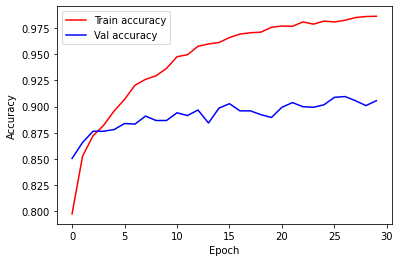

In [ ]:
n_epochs=30
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m9],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m9],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

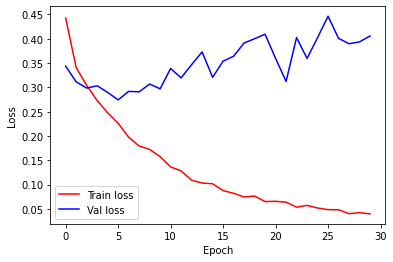

In [ ]:
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m9,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m9,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 9

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model10 = torchvision.models.efficientnet_b0(weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model10.classifier[1].in_features
model10.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs,2)
)

#ct=0
#for child in model9.children():
#  ct += 1
#  if ct < 2:
#    for param in child.parameters():
#      param.requires_grad = False
# Move the model to the device
model10 = model10.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model9.parameters(),lr=0.001)
optimizer = optim.Adam(model10.parameters(), lr=0.0001)

summary(model10, input_size=(3,224,224), batch_size=32)

dataloaders= {'train':train_loader,'val': valid_loader}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [ ]:
model_10,weights_m10, train_acc_m10, train_loss_m10, val_acc_m10, val_loss_m10= train_model(model10,dataloaders,criterion,optimizer,15,False)

Epoch 1/15: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.4142 , train Accuracy: 0.8105


Epoch 1/15: 100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


val Loss: 0.3530 , val Accuracy: 0.8440
----------------------------------------------------------------------


Epoch 2/15: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.3350 , train Accuracy: 0.8542


Epoch 2/15: 100%|██████████| 119/119 [00:47<00:00,  2.51it/s]


val Loss: 0.3195 , val Accuracy: 0.8612
----------------------------------------------------------------------


Epoch 3/15: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.3002 , train Accuracy: 0.8679


Epoch 3/15: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.2920 , val Accuracy: 0.8701
----------------------------------------------------------------------


Epoch 4/15: 100%|██████████| 475/475 [03:15<00:00,  2.43it/s]


train Loss: 0.2706 , train Accuracy: 0.8848


Epoch 4/15: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.2957 , val Accuracy: 0.8733
----------------------------------------------------------------------


Epoch 5/15: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.2430 , train Accuracy: 0.8960


Epoch 5/15: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.2908 , val Accuracy: 0.8754
----------------------------------------------------------------------


Epoch 6/15: 100%|██████████| 475/475 [03:17<00:00,  2.41it/s]


train Loss: 0.2260 , train Accuracy: 0.9044


Epoch 6/15: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]


val Loss: 0.2884 , val Accuracy: 0.8836
----------------------------------------------------------------------


Epoch 7/15: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.2102 , train Accuracy: 0.9129


Epoch 7/15: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.2822 , val Accuracy: 0.8846
----------------------------------------------------------------------


Epoch 8/15: 100%|██████████| 475/475 [03:16<00:00,  2.41it/s]


train Loss: 0.1896 , train Accuracy: 0.9201


Epoch 8/15: 100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


val Loss: 0.2807 , val Accuracy: 0.8904
----------------------------------------------------------------------


Epoch 9/15: 100%|██████████| 475/475 [03:19<00:00,  2.38it/s]


train Loss: 0.1725 , train Accuracy: 0.9293


Epoch 9/15: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]


val Loss: 0.3016 , val Accuracy: 0.8930
----------------------------------------------------------------------


Epoch 10/15: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1603 , train Accuracy: 0.9330


Epoch 10/15: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.2893 , val Accuracy: 0.8859
----------------------------------------------------------------------


Epoch 11/15: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.1473 , train Accuracy: 0.9399


Epoch 11/15: 100%|██████████| 119/119 [00:46<00:00,  2.56it/s]


val Loss: 0.3058 , val Accuracy: 0.8880
----------------------------------------------------------------------


Epoch 12/15: 100%|██████████| 475/475 [03:18<00:00,  2.40it/s]


train Loss: 0.1322 , train Accuracy: 0.9447


Epoch 12/15: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


val Loss: 0.2996 , val Accuracy: 0.8923
----------------------------------------------------------------------


Epoch 13/15: 100%|██████████| 475/475 [03:17<00:00,  2.40it/s]


train Loss: 0.1238 , train Accuracy: 0.9499


Epoch 13/15: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]


val Loss: 0.3036 , val Accuracy: 0.8896
----------------------------------------------------------------------


Epoch 14/15: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1160 , train Accuracy: 0.9548


Epoch 14/15: 100%|██████████| 119/119 [00:46<00:00,  2.54it/s]


val Loss: 0.3196 , val Accuracy: 0.8962
----------------------------------------------------------------------


Epoch 15/15: 100%|██████████| 475/475 [03:18<00:00,  2.39it/s]


train Loss: 0.1104 , train Accuracy: 0.9577


Epoch 15/15: 100%|██████████| 119/119 [00:46<00:00,  2.55it/s]

val Loss: 0.3136 , val Accuracy: 0.8920
----------------------------------------------------------------------
Training complete in 61m 12s
Best val Acc: 0.896207


In [ ]:
pickle.dump(model_10, open(models_directory+'/model_10.sav', 'wb'))
pickle.dump(weights_m10, open(models_directory+'/weights_m10.sav', 'wb'))
pickle.dump(train_acc_m10, open(models_directory+'/train_acc_m10.sav', 'wb'))
pickle.dump(train_loss_m10, open(models_directory+'/train_loss_m10.sav', 'wb'))
pickle.dump(val_acc_m10, open(models_directory+'/val_acc_m10.sav', 'wb'))
pickle.dump(val_loss_m10, open(models_directory+'/val_loss_m10.sav', 'wb'))

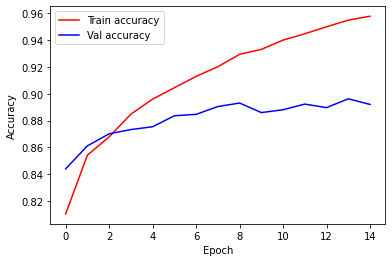

In [ ]:
n_epochs=15
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), [a.tolist() for a in train_acc_m10],'r',label='Train accuracy')
plt.plot(range(n_epochs), [a.tolist() for a in val_acc_m10],'b', label= 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

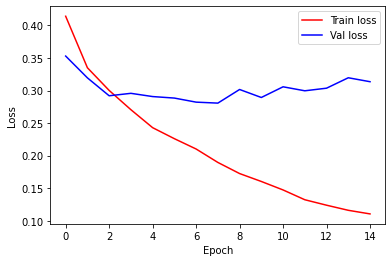

In [ ]:
#plt.figure(figsize=(10,8))
plt.plot(range(n_epochs), train_loss_m10,'r',label='Train loss')
plt.plot(range(n_epochs), val_loss_m10,'b', label= 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 10

In [ ]:
# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model
model11 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the fully connected layer with a new one with 2 classes
num_ftrs = model11.fc.in_features
model11.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model11 = model11.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model11.parameters(), lr=0.0001)

dataloaders= {'train':train_loader,'val': valid_loader}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_11,weights_m11, train_acc_m11, train_loss_m11, val_acc_m11, val_loss_m11= train_model(model11,dataloaders,criterion,optimizer,MAX_NUM_EPOCHS,False)

  0%|          | 0/950 [00:00<?, ?it/s]

In [ ]:
pickle.dump(model_11, open(models_directory+'/model_11.sav', 'wb'))
pickle.dump(weights_m11, open(models_directory+'/weights_m11.sav', 'wb'))
pickle.dump(train_acc_m11, open(models_directory+'/train_acc_m11.sav', 'wb'))
pickle.dump(train_loss_m11, open(models_directory+'/train_loss_m11.sav', 'wb'))
pickle.dump(val_acc_m11, open(models_directory+'/val_acc_m11.sav', 'wb'))
pickle.dump(val_loss_m11, open(models_directory+'/val_loss_m11.sav', 'wb'))

NameError: ignored